In [1]:
# getting all the necessary imports
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import shutil
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import os
import torch.nn.functional as F

In [2]:
# the dataset without features is unstructured, with 15000 images
# this snippet is written to structure it so it can be easier to use
# all the handwriting samples belonging to one author will be sent to a directory with the author's name
for root, dirs, files in os.walk("C:/Users/ashwi/Downloads/AND_dataset(1)/AND_dataset/Dataset[Without-Features]/AND_Images[WithoutFeatures]/"):
    for file in files:
        if file.endswith(".png"):
            person = str(file)[:4]
            person_dir = root + person + "/"
            if os.path.exists(person_dir):
                os.rename(os.path.join(root, file), os.path.join(person_dir, file))
            else:
                os.makedirs(person_dir)
                os.rename(os.path.join(root, file), os.path.join(person_dir, file))
            #print(person_dir)

In [3]:
# defining function to display an image
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# defining function to show the plot
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
# configuration class that defines important variables
# by doing this, when the configuration changes, one change
# can apply to the entire pipeline
class Configuration():
    training_directory = "./data/faces/training/"
    testing_directory = "./data/faces/testing/"
    training_batch_size = 32
    training_number_of_epochs = 50

In [5]:
# defining a custom data loader class that inherits Dataset
# since we have a unique requirement in this project it called for a custom class
# to maintain class balance, a 1 or 0 is randomly sampled
# based on 1 or 0, a pair of images are taken either from the same or different authors

class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        
        # write the file pairs to a text file for later use 
        # this was used to get some data for the simple machine learing approach
        # not necessary to run for the deep learning approach
        #file= open("filepairs.txt","a")
        #file.write(img0_tuple[0][-14:])
        #file.write(" ")
        #file.write(img1_tuple[0][-14:] + "\n")
        #file.close()
        
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
dataset_directory = dset.ImageFolder(root=Configuration.training_directory)

In [7]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=dataset_directory,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]),
                                       should_invert=False)

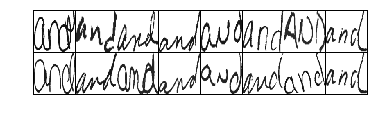

[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]]


In [8]:
# brief visualization of the the pairs of data
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
data_iter = iter(vis_dataloader)


example_batch = next(data_iter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [9]:
# defining the architecture of our neural network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [10]:
# defining the contrastive loss that is used in this approach
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [11]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Configuration.training_batch_size)

In [12]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [13]:
# initializing variables
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.8214794397354126

Epoch number 0
 Current loss 0.6732221245765686

Epoch number 0
 Current loss 1.014717698097229

Epoch number 0
 Current loss 0.5816832780838013

Epoch number 0
 Current loss 0.9476534128189087

Epoch number 0
 Current loss 1.1145716905593872

Epoch number 0
 Current loss 1.047080397605896

Epoch number 0
 Current loss 0.6728387475013733

Epoch number 0
 Current loss 1.1786324977874756

Epoch number 0
 Current loss 1.2259259223937988

Epoch number 0
 Current loss 0.761396050453186

Epoch number 0
 Current loss 0.5168556571006775

Epoch number 0
 Current loss 0.6387299299240112

Epoch number 0
 Current loss 0.7685267925262451

Epoch number 0
 Current loss 0.9793677926063538

Epoch number 0
 Current loss 0.8150768876075745

Epoch number 0
 Current loss 1.0050580501556396

Epoch number 0
 Current loss 0.8044779300689697

Epoch number 0
 Current loss 1.1112850904464722

Epoch number 0
 Current loss 0.7250916361808777

Epoch number 0
 Current


Epoch number 4
 Current loss 0.6330145001411438

Epoch number 4
 Current loss 0.40149766206741333

Epoch number 4
 Current loss 0.4076254367828369

Epoch number 4
 Current loss 0.5000649094581604

Epoch number 4
 Current loss 0.27050960063934326

Epoch number 4
 Current loss 0.6313118934631348

Epoch number 4
 Current loss 0.2502448856830597

Epoch number 4
 Current loss 0.4521577060222626

Epoch number 4
 Current loss 0.3133702576160431

Epoch number 4
 Current loss 0.46375274658203125

Epoch number 4
 Current loss 0.4846324026584625

Epoch number 4
 Current loss 0.3688431680202484

Epoch number 4
 Current loss 0.4362263083457947

Epoch number 4
 Current loss 0.4808531105518341

Epoch number 4
 Current loss 0.3910053074359894

Epoch number 4
 Current loss 0.5174205899238586

Epoch number 4
 Current loss 0.5092299580574036

Epoch number 4
 Current loss 0.4810692071914673

Epoch number 4
 Current loss 0.3845524489879608

Epoch number 4
 Current loss 0.4455094039440155

Epoch number 4
 


Epoch number 8
 Current loss 0.2990628778934479

Epoch number 8
 Current loss 0.5493939518928528

Epoch number 8
 Current loss 0.17798133194446564

Epoch number 8
 Current loss 0.40506893396377563

Epoch number 8
 Current loss 0.3673563003540039

Epoch number 8
 Current loss 0.4697491526603699

Epoch number 8
 Current loss 0.2530348300933838

Epoch number 8
 Current loss 0.4086909890174866

Epoch number 8
 Current loss 0.25951117277145386

Epoch number 8
 Current loss 0.4211735129356384

Epoch number 8
 Current loss 0.2592051923274994

Epoch number 8
 Current loss 0.33658483624458313

Epoch number 8
 Current loss 0.25711652636528015

Epoch number 8
 Current loss 0.2460838258266449

Epoch number 8
 Current loss 0.21456779539585114

Epoch number 8
 Current loss 0.41240057349205017

Epoch number 9
 Current loss 0.45253437757492065

Epoch number 9
 Current loss 0.35409101843833923

Epoch number 9
 Current loss 0.3498230278491974

Epoch number 9
 Current loss 0.5385236740112305

Epoch numb


Epoch number 12
 Current loss 0.35924845933914185

Epoch number 12
 Current loss 0.5981062054634094

Epoch number 12
 Current loss 0.19769729673862457

Epoch number 12
 Current loss 0.308916836977005

Epoch number 12
 Current loss 0.2371072620153427

Epoch number 12
 Current loss 0.3880838453769684

Epoch number 12
 Current loss 0.08987126499414444

Epoch number 12
 Current loss 0.3209892213344574

Epoch number 13
 Current loss 0.2431441694498062

Epoch number 13
 Current loss 0.21833990514278412

Epoch number 13
 Current loss 0.3222254514694214

Epoch number 13
 Current loss 0.24574972689151764

Epoch number 13
 Current loss 0.3576709032058716

Epoch number 13
 Current loss 0.47899577021598816

Epoch number 13
 Current loss 0.21516013145446777

Epoch number 13
 Current loss 0.35788244009017944

Epoch number 13
 Current loss 0.26319798827171326

Epoch number 13
 Current loss 0.44620490074157715

Epoch number 13
 Current loss 0.24732749164104462

Epoch number 13
 Current loss 0.1956790


Epoch number 16
 Current loss 0.16657571494579315

Epoch number 17
 Current loss 0.17938198149204254

Epoch number 17
 Current loss 0.1407480090856552

Epoch number 17
 Current loss 0.2866874635219574

Epoch number 17
 Current loss 0.1446634978055954

Epoch number 17
 Current loss 0.20629309117794037

Epoch number 17
 Current loss 0.12147587537765503

Epoch number 17
 Current loss 0.3014366924762726

Epoch number 17
 Current loss 0.21652710437774658

Epoch number 17
 Current loss 0.17494553327560425

Epoch number 17
 Current loss 0.21898947656154633

Epoch number 17
 Current loss 0.17704565823078156

Epoch number 17
 Current loss 0.22545956075191498

Epoch number 17
 Current loss 0.23308324813842773

Epoch number 17
 Current loss 0.14131899178028107

Epoch number 17
 Current loss 0.2161465883255005

Epoch number 17
 Current loss 0.18098688125610352

Epoch number 17
 Current loss 0.16288480162620544

Epoch number 17
 Current loss 0.3517206013202667

Epoch number 17
 Current loss 0.2434


Epoch number 21
 Current loss 0.16145852208137512

Epoch number 21
 Current loss 0.19315022230148315

Epoch number 21
 Current loss 0.1561211347579956

Epoch number 21
 Current loss 0.3490930497646332

Epoch number 21
 Current loss 0.13594743609428406

Epoch number 21
 Current loss 0.21198172867298126

Epoch number 21
 Current loss 0.10197954624891281

Epoch number 21
 Current loss 0.275448203086853

Epoch number 21
 Current loss 0.14405103027820587

Epoch number 21
 Current loss 0.17890457808971405

Epoch number 21
 Current loss 0.2083258032798767

Epoch number 21
 Current loss 0.0644816979765892

Epoch number 21
 Current loss 0.1068669930100441

Epoch number 21
 Current loss 0.2330588400363922

Epoch number 21
 Current loss 0.15446193516254425

Epoch number 21
 Current loss 0.1811816394329071

Epoch number 21
 Current loss 0.2314123958349228

Epoch number 21
 Current loss 0.14763639867305756

Epoch number 21
 Current loss 0.1787041425704956

Epoch number 21
 Current loss 0.219871312


Epoch number 25
 Current loss 0.18824325501918793

Epoch number 25
 Current loss 0.11219991743564606

Epoch number 25
 Current loss 0.18016807734966278

Epoch number 25
 Current loss 0.06766917556524277

Epoch number 25
 Current loss 0.2758294939994812

Epoch number 25
 Current loss 0.12344159185886383

Epoch number 25
 Current loss 0.2041669487953186

Epoch number 25
 Current loss 0.20515455305576324

Epoch number 25
 Current loss 0.2497107833623886

Epoch number 25
 Current loss 0.07902522385120392

Epoch number 25
 Current loss 0.1095542460680008

Epoch number 25
 Current loss 0.11345826834440231

Epoch number 25
 Current loss 0.20561183989048004

Epoch number 25
 Current loss 0.149457648396492

Epoch number 25
 Current loss 0.1304493546485901

Epoch number 25
 Current loss 0.1862901896238327

Epoch number 25
 Current loss 0.21986296772956848

Epoch number 25
 Current loss 0.1297340840101242

Epoch number 25
 Current loss 0.22068548202514648

Epoch number 25
 Current loss 0.2178413


Epoch number 29
 Current loss 0.10072912275791168

Epoch number 29
 Current loss 0.21461965143680573

Epoch number 29
 Current loss 0.1721303015947342

Epoch number 29
 Current loss 0.1953473538160324

Epoch number 29
 Current loss 0.15712840855121613

Epoch number 29
 Current loss 0.11503611505031586

Epoch number 29
 Current loss 0.2526642978191376

Epoch number 29
 Current loss 0.19006577134132385

Epoch number 29
 Current loss 0.08069252967834473

Epoch number 29
 Current loss 0.08200933039188385

Epoch number 29
 Current loss 0.11862004548311234

Epoch number 29
 Current loss 0.2736775577068329

Epoch number 29
 Current loss 0.12286128848791122

Epoch number 29
 Current loss 0.1090698093175888

Epoch number 29
 Current loss 0.1506601721048355

Epoch number 29
 Current loss 0.09407269954681396

Epoch number 29
 Current loss 0.22086185216903687

Epoch number 29
 Current loss 0.12673264741897583

Epoch number 29
 Current loss 0.10160946100950241

Epoch number 29
 Current loss 0.1659


Epoch number 33
 Current loss 0.23862594366073608

Epoch number 33
 Current loss 0.17694614827632904

Epoch number 33
 Current loss 0.12631365656852722

Epoch number 33
 Current loss 0.25921615958213806

Epoch number 33
 Current loss 0.23253586888313293

Epoch number 33
 Current loss 0.13516756892204285

Epoch number 33
 Current loss 0.27680936455726624

Epoch number 33
 Current loss 0.18861012160778046

Epoch number 33
 Current loss 0.07657285779714584

Epoch number 33
 Current loss 0.08715377002954483

Epoch number 33
 Current loss 0.07874266803264618

Epoch number 33
 Current loss 0.14255568385124207

Epoch number 33
 Current loss 0.25246724486351013

Epoch number 33
 Current loss 0.07281431555747986

Epoch number 33
 Current loss 0.25578975677490234

Epoch number 33
 Current loss 0.26733097434043884

Epoch number 34
 Current loss 0.0949903354048729

Epoch number 34
 Current loss 0.13849064707756042

Epoch number 34
 Current loss 0.1804189532995224

Epoch number 34
 Current loss 0.


Epoch number 37
 Current loss 0.1411425918340683

Epoch number 37
 Current loss 0.05489690974354744

Epoch number 37
 Current loss 0.06574959307909012

Epoch number 37
 Current loss 0.04757385328412056

Epoch number 37
 Current loss 0.07611750066280365

Epoch number 37
 Current loss 0.06871221214532852

Epoch number 37
 Current loss 0.11662828922271729

Epoch number 37
 Current loss 0.09547438472509384

Epoch number 37
 Current loss 0.17222310602664948

Epoch number 37
 Current loss 0.16230043768882751

Epoch number 38
 Current loss 0.1770257204771042

Epoch number 38
 Current loss 0.21747393906116486

Epoch number 38
 Current loss 0.20263895392417908

Epoch number 38
 Current loss 0.028607673943042755

Epoch number 38
 Current loss 0.11554932594299316

Epoch number 38
 Current loss 0.1143251284956932

Epoch number 38
 Current loss 0.08182511478662491

Epoch number 38
 Current loss 0.11277243494987488

Epoch number 38
 Current loss 0.07035396248102188

Epoch number 38
 Current loss 0.


Epoch number 41
 Current loss 0.06131856516003609

Epoch number 41
 Current loss 0.09347793459892273

Epoch number 41
 Current loss 0.06758730858564377

Epoch number 41
 Current loss 0.07478944212198257

Epoch number 42
 Current loss 0.11350831389427185

Epoch number 42
 Current loss 0.1344738006591797

Epoch number 42
 Current loss 0.07358956336975098

Epoch number 42
 Current loss 0.06350915879011154

Epoch number 42
 Current loss 0.179147407412529

Epoch number 42
 Current loss 0.09526339173316956

Epoch number 42
 Current loss 0.05340217798948288

Epoch number 42
 Current loss 0.14294783771038055

Epoch number 42
 Current loss 0.09419318288564682

Epoch number 42
 Current loss 0.15104812383651733

Epoch number 42
 Current loss 0.11007270961999893

Epoch number 42
 Current loss 0.08896894752979279

Epoch number 42
 Current loss 0.04055887460708618

Epoch number 42
 Current loss 0.08094115555286407

Epoch number 42
 Current loss 0.08708930760622025

Epoch number 42
 Current loss 0.1


Epoch number 46
 Current loss 0.044774677604436874

Epoch number 46
 Current loss 0.0723414197564125

Epoch number 46
 Current loss 0.11244406551122665

Epoch number 46
 Current loss 0.09682454913854599

Epoch number 46
 Current loss 0.07565401494503021

Epoch number 46
 Current loss 0.04682313650846481

Epoch number 46
 Current loss 0.11414466798305511

Epoch number 46
 Current loss 0.045694638043642044

Epoch number 46
 Current loss 0.07748019695281982

Epoch number 46
 Current loss 0.1666288822889328

Epoch number 46
 Current loss 0.04141848161816597

Epoch number 46
 Current loss 0.11998628079891205

Epoch number 46
 Current loss 0.0783572643995285

Epoch number 46
 Current loss 0.09350335597991943

Epoch number 46
 Current loss 0.12048757821321487

Epoch number 46
 Current loss 0.10894376039505005

Epoch number 46
 Current loss 0.11799120903015137

Epoch number 46
 Current loss 0.06560179591178894

Epoch number 46
 Current loss 0.14656466245651245

Epoch number 46
 Current loss 0

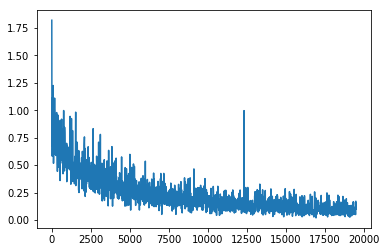

In [14]:
for epoch in range(0,Configuration.training_number_of_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

In [16]:
# creating a test data loader
folder_dataset_test = dset.ImageFolder(root=Configuration.testing_directory)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)

In [17]:
# retrieving the dissimilarity measures and ground truth labels for the test set
dissimilarity_measures = []
ground_truth_labels = []
for i, data in enumerate(test_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        euclidean_distance = euclidean_distance.cpu().data.numpy()[0][0]
        dissimilarity_measures.append(euclidean_distance)
        ground_truth_labels.append(int(label.cpu().data.numpy()[0][0]))

In [18]:
# we get a dissimilarity measure from this process 
# but in order to measure accuracy, we need a label of 0 or 1
# to do this, we take the meadian dissimilarity measure,
# everything above this value is taken as 1 and everything else is 0
predicted_labels = []
maximum = np.max(dissimilarity_measures)
med = np.median(dissimilarity_measures) / maximum

for i in dissimilarity_measures:
    value = i/maximum
    if(value > med):
        label = 1
    else:
        label = 0
    predicted_labels.append(label)

In [22]:
# now we use the list of predicted labels and ground truth labels to calculate accuracy
matches = np.equal(predicted_labels, ground_truth_labels)

n = 0
for i in matches:
    if(i):
        n = n + 1

# matches divided by length of the list should give us accuracy
print("Accuracy: " + str(n*100 / len(ground_truth_labels))+"%")

Accuracy: 77.19508540605334%
